In [ ]:
from dotenv import load_dotenv
import os
load_dotenv("Your_Path_To/API_Key.env")
API_KEY = os.getenv("TMDB_API_KEY") 
if not API_KEY:
    raise ValueError("API Key not found! Check your .env file.")
print(f"Your API Key: {API_KEY}")

In [3]:
pip install requests pandas sqlite3 python-dotenv

ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for sqlite3
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import requests
import json
import time
import pandas as pd
import sqlite3
from dotenv import load_dotenv

In [5]:
load_dotenv()
API_KEY = os.getenv("TMDB_API_KEY")
if not API_KEY:
    raise ValueError("API Key not found! Set TMDB_API_KEY in .env file.")


In [ ]:
BASE_URL = "https://api.themoviedb.org/3"
UPLOAD_FOLDER = os.path.expanduser("~/Desktop/")
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

json_file_path = os.path.join(UPLOAD_FOLDER, "top_rated_movies.json")
csv_file_path = os.path.join(UPLOAD_FOLDER, "cleaned_top_rated_movies.csv")
db_file_path = os.path.join(UPLOAD_FOLDER, "top_rated_movies.db")
top_movies = []
page = 1

In [7]:
while len(top_movies) < 500:
    url = f"{BASE_URL}/movie/popular?api_key={API_KEY}&page={page}"
    
    for attempt in range(3):  # Retry mechanism (3 attempts)
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            top_movies.extend(data['results'])
            break  # Exit retry loop if successful
        else:
            print(f"Request failed (Attempt {attempt+1}): {response.status_code}")
            time.sleep(2)  # Wait before retrying
    else:
        print("Failed to fetch data after 3 attempts. Exiting.")
        break

    if len(data['results']) < 20:  # Stop if there are no more pages
        break
    page += 1

In [8]:
if os.path.exists(json_file_path):
    with open(json_file_path, 'r') as file:
        existing_movies = json.load(file)
else:
    existing_movies = []
existing_movie_ids = {movie['id'] for movie in existing_movies}
new_movies = [movie for movie in top_movies if movie['id'] not in existing_movie_ids]

In [9]:
if new_movies:
    with open(json_file_path, 'w') as file:
        json.dump(existing_movies + new_movies, file, indent=4)

In [10]:
df = pd.DataFrame(existing_movies + new_movies)

In [11]:
columns_to_keep = ['id', 'title', 'release_date', 'overview', 'vote_average', 'popularity']
df_cleaned = df[columns_to_keep]

In [12]:
df_cleaned.dropna(subset=['title', 'release_date'], inplace=True)
df_cleaned['release_date'] = pd.to_datetime(df_cleaned['release_date'], errors='coerce')
df_cleaned['vote_average'] = pd.to_numeric(df_cleaned['vote_average'], errors='coerce')
df_cleaned['popularity'] = pd.to_numeric(df_cleaned['popularity'], errors='coerce')
df_cleaned = df_cleaned[(df_cleaned['vote_average'] >= 0) & (df_cleaned['vote_average'] <= 10)]
df_cleaned = df_cleaned[df_cleaned['popularity'] >= 0]

/var/folders/x0/hpk7qbjn6l718dnwlnclr80m0000gn/T/ipykernel_13528/1060507948.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.dropna(subset=['title', 'release_date'], inplace=True)
/var/folders/x0/hpk7qbjn6l718dnwlnclr80m0000gn/T/ipykernel_13528/1060507948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['release_date'] = pd.to_datetime(df_cleaned['release_date'], errors='coerce')
/var/folders/x0/hpk7qbjn6l718dnwlnclr80m0000gn/T/ipykernel_13528/1060507948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [13]:
df_cleaned.to_csv(csv_file_path, index=False)

In [34]:
conn = sqlite3.connect(db_file_path)
existing_ids = pd.read_sql("SELECT id FROM top_movies", conn)['id'].tolist() if "top_movies" in conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall() else []
df_cleaned = df_cleaned[~df_cleaned['id'].isin(existing_ids)]
df_cleaned.to_sql('top_movies', conn, if_exists='append', index=False)
conn.commit()
conn.close()

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Alternative Way of Automated the process using a Function

In [14]:
def clean_and_save_dataframe(df, csv_file_path):
    columns_to_keep = ['id', 'title', 'release_date', 'overview', 'vote_average', 'popularity']
    df_cleaned = df[columns_to_keep]
    df_cleaned.dropna(subset=['title', 'release_date'], inplace=True)
    df_cleaned['release_date'] = pd.to_datetime(df_cleaned['release_date'], errors='coerce')
    df_cleaned['vote_average'] = pd.to_numeric(df_cleaned['vote_average'], errors='coerce')
    df_cleaned['popularity'] = pd.to_numeric(df_cleaned['popularity'], errors='coerce')
    df_cleaned = df_cleaned[(df_cleaned['vote_average'] >= 0) & (df_cleaned['vote_average'] <= 10)]
    df_cleaned = df_cleaned[df_cleaned['popularity'] >= 0]
    df_cleaned.to_csv(csv_file_path, index=False)

In [15]:
import sqlite3
import pandas as pd

def append_to_database(df_cleaned, db_file_path):
    conn = sqlite3.connect(db_file_path)
    table_exists = "top_movies" in [t[0] for t in conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()]
    if table_exists:
        existing_ids = pd.read_sql("SELECT id FROM top_movies", conn)['id'].tolist()
    else:
        existing_ids = []
    df_cleaned = df_cleaned[~df_cleaned['id'].isin(existing_ids)]
    if not df_cleaned.empty:
        df_cleaned.to_sql('top_movies', conn, if_exists='append', index=False)
        conn.commit()
    conn.close()

Vote Average Distribution

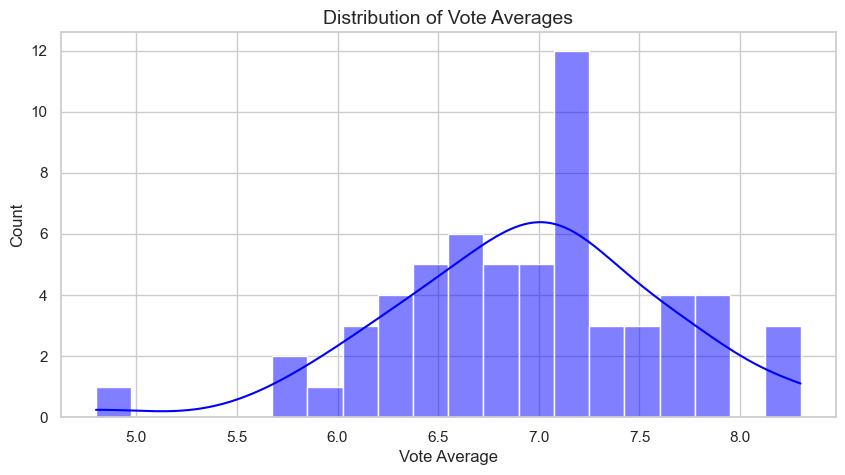

In [ ]:
csv_file_path = 'your_path_to_the_csv_file'
df = pd.read_csv(csv_file_path)
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(df['vote_average'], bins=20, kde=True, color="blue")
plt.title('Distribution of Vote Averages', fontsize=14)
plt.xlabel('Vote Average')
plt.ylabel('Count')
plt.show()

Top 10 Most Popular Movies

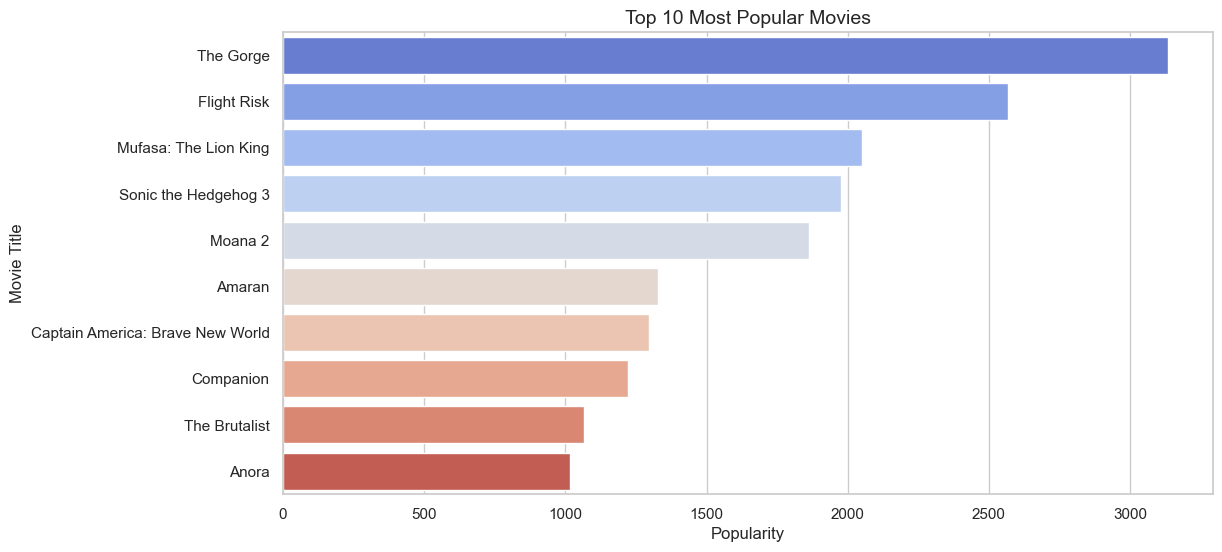

In [39]:
top_popular = df.nlargest(10, 'popularity')
plt.figure(figsize=(12, 6))
sns.barplot(y=top_popular['title'], x=top_popular['popularity'], palette="coolwarm")
plt.title('Top 10 Most Popular Movies', fontsize=14)
plt.xlabel('Popularity')
plt.ylabel('Movie Title')
plt.show()

Number of Movies Released per Year

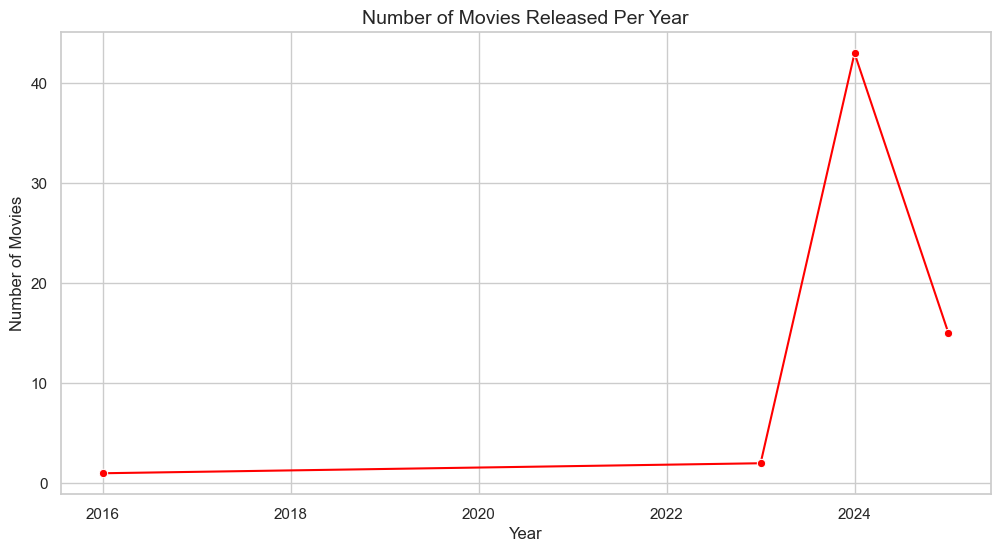

In [40]:
yearly_count = df.groupby('year').size().reset_index(name='count')
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_count, x='year', y='count', marker='o', color='red')
plt.title('Number of Movies Released Per Year', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

In [ ]:
import sqlite3
import pandas as pd

# SQLite Database File
db_file_path = 'Your/Path/To/top_rated_movies.db'

# Function to fetch top-rated movies
def fetch_top_rated_movies(year=None, min_rating=0, max_rating=10, min_popularity=0):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_file_path)
    
    # Build the query
    query = """
    SELECT * FROM top_movies
    WHERE vote_average BETWEEN ? AND ?
    AND popularity >= ?
    """
    
    # Add year filter if specified
    if year:
        query += " AND strftime('%Y', release_date) = ?"
        params = (min_rating, max_rating, min_popularity, str(year))
    else:
        params = (min_rating, max_rating, min_popularity)
    
    # Execute the query
    df = pd.read_sql(query, conn, params=params)
    conn.close()
    
    return df

# Example 1: Fetch top-rated movies from the year 2020 with ratings between 8 and 10
top_rated_2020 = fetch_top_rated_movies(year=2020, min_rating=8, max_rating=10)
print("Top-rated movies from 2020 with ratings between 8 and 10:")
print(top_rated_2020[['title', 'vote_average', 'release_date', 'popularity']])

# Example 2: Fetch popular movies with ratings above 7
popular_movies_above_7 = fetch_top_rated_movies(min_rating=7, min_popularity=50)
print("\nPopular movies with ratings above 7 and popularity above 50:")
print(popular_movies_above_7[['title', 'vote_average', 'release_date', 'popularity']])

Top-rated movies from 2020 with ratings between 8 and 10:
Empty DataFrame
Columns: [title, vote_average, release_date, popularity]
Index: []

Popular movies with ratings above 7 and popularity above 50:
                    title  vote_average         release_date  popularity
0               The Gorge         7.791           2025-02-13    3135.209
1   Mufasa: The Lion King         7.467           2024-12-18    2050.558
2    Sonic the Hedgehog 3         7.700           2024-12-19    1976.892
3                 Moana 2         7.149           2024-11-21    1861.245
4                  Amaran         7.400           2024-10-31    1329.454
..                    ...           ...                  ...         ...
93         Alien: Romulus         7.200  2024-08-13 00:00:00     280.422
94         I'm Still Here         7.900  2024-09-19 00:00:00     327.782
95  Bad Boys: Ride or Die         7.384  2024-06-05 00:00:00     306.478
96              Mickey 17         7.700  2025-02-28 00:00:00     42

In [ ]:
import sqlite3
db_file_path = 'Your/Path/To/top_rated_movies.db'
conn = sqlite3.connect(db_file_path)

In [45]:
query_top_rated = """
SELECT title, vote_average, popularity, release_date 
FROM top_movies 
ORDER BY vote_average DESC 
LIMIT 10
"""
top_rated_movies = pd.read_sql(query_top_rated, conn)
print("\n🔹 Top 10 Highest Rated Movies:\n", top_rated_movies)


🔹 Top 10 Highest Rated Movies:
             title  vote_average  popularity         release_date
0            Flow           8.3     885.787           2024-08-29
1            Flow           8.3     885.787           2024-08-29
2  The Wild Robot           8.3     500.759           2024-09-12
3            Flow           8.3     885.787  2024-08-29 00:00:00
4            Flow           8.3     885.787  2024-08-29 00:00:00
5  The Wild Robot           8.3     500.759  2024-09-12 00:00:00
6            Flow           8.3     885.787  2024-08-29 00:00:00
7            Flow           8.3     885.787  2024-08-29 00:00:00
8  The Wild Robot           8.3     500.759  2024-09-12 00:00:00
9  I'm Still Here           7.9     327.782           2024-09-19


In [46]:
year = 2023
query_by_year = f"""
SELECT title, vote_average, popularity, release_date 
FROM top_movies 
WHERE release_date LIKE '{year}%' 
ORDER BY vote_average DESC
"""
movies_2023 = pd.read_sql(query_by_year, conn)
print(f"\n🔹 Movies Released in {year}:\n", movies_2023)



🔹 Movies Released in 2023:
         title  vote_average  popularity         release_date
0    My Fault         7.800     325.215           2023-06-08
1    My Fault         7.800     325.215  2023-06-08 00:00:00
2    My Fault         7.800     325.215  2023-06-08 00:00:00
3  The Island         6.096     500.048           2023-07-21
4  The Island         6.096     500.048  2023-07-21 00:00:00
5  The Island         6.096     500.048  2023-07-21 00:00:00


In [47]:
year = 2022
query_popular_year = f"""
SELECT title, popularity, vote_average, release_date 
FROM top_movies 
WHERE release_date LIKE '{year}%' 
ORDER BY popularity DESC 
LIMIT 10
"""
popular_movies_2022 = pd.read_sql(query_popular_year, conn)
print(f"\n🔹 Most Popular Movies in {year}:\n", popular_movies_2022)


🔹 Most Popular Movies in 2022:
 Empty DataFrame
Columns: [title, popularity, vote_average, release_date]
Index: []


In [53]:
query_avg_ratings = """
SELECT strftime('%Y', release_date) AS year, AVG(vote_average) AS avg_rating
FROM top_movies 
GROUP BY year
HAVING year IS NOT NULL
ORDER BY year DESC
"""
avg_ratings_per_year = pd.read_sql(query_avg_ratings, conn)
print("\n🔹 Average Ratings Per Year:\n", avg_ratings_per_year)


🔹 Average Ratings Per Year:
    year  avg_rating
0  2025    6.556568
1  2024    7.080000
2  2023    6.948000
3  2016    7.100000


In [54]:
conn.close()